In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


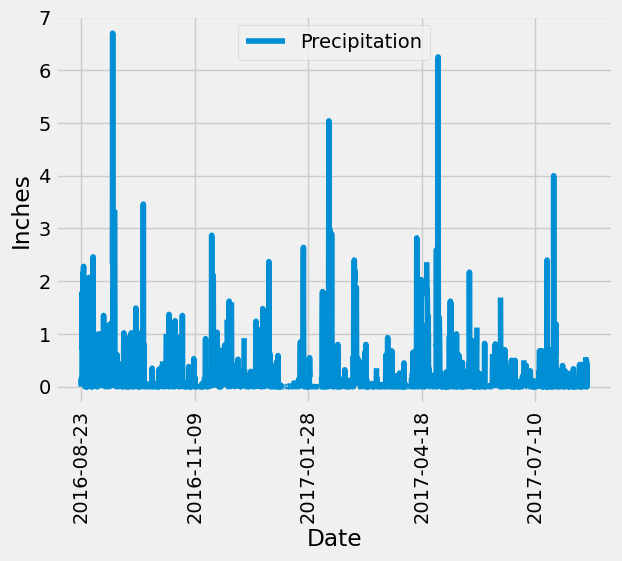

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
# start_date = last_date - dt.timedelta(days=365)
start_date = dt.date(2017,8,23) - dt.timedelta(days=365)
#print(start_date)

# Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date>=start_date).order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_scores, columns=['date', 'prcp'])
precipitation_df = precipitation_df.rename(columns={'date': "Date", 'prcp': "Precipitation"})

# Sort the dataframe by date
sort_df = precipitation_df.sort_values("Date")
sort_df = sort_df.set_index("Date")

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_bar = sort_df.plot(xlabel="Date", ylabel="Inches", rot=90)
# plt.xticks = np.linspace(0, len(sort_df)-1, 9, dtype=int)
# plt.xticks(x_ticks, sort_df.index[x_ticks], rotation='vertical')
# plt.ylim(-.5, 7)
# plt.legend(loc='upper middle')
# plt.tight_layout()

plt.show()
# Save image 
precipitation_bar.figure.savefig('2016-2017_precipitationbar.png', bbox_inches='tight')


In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
sort_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(func.count((station.station))).all()
stations

[(9,)]

In [20]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [measurement.station, 
       func.count(measurement.date)]
active_stations = session.query(*sel).\
        group_by(measurement.station).\
        order_by(func.count(measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [measurement.station,
       func.min(measurement.tobs), 
       func.max(measurement.tobs),
       func.avg(measurement.tobs)]
station_temp_summary = session.query(*sel).\
        filter(measurement.station == 'USC00519281').\
        group_by(measurement.station)
for station in station_temp_summary:
    print(station)

('USC00519281', 54.0, 85.0, 71.66378066378067)


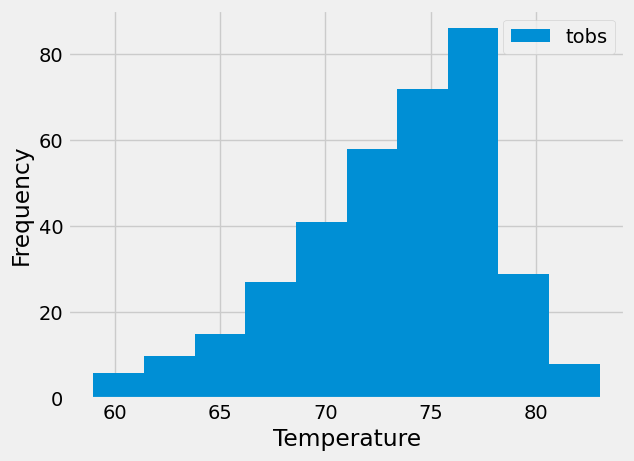

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [measurement.date, 
       measurement.tobs]
station_temps = session.query(*sel).\
        filter(func.strftime(measurement.date) >= start_date, measurement.station == 'USC00519281').\
        group_by(measurement.date).\
        order_by(measurement.date).all()

#Dataframe containing the results of this query
station_temps_df = pd.DataFrame(station_temps, columns=['Measurement Date', 'Temperature'])

# Histogram to visualize temperature and frequency 
plt.hist(station_temps_df['Temperature'], label="tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Close Session

In [23]:
# Close Session
session.close()